In [1]:
from theory import *

In [2]:
import numpy as np
from torch_geometric.datasets import Planetoid
from sklearn.decomposition import PCA
from torch_geometric.data import ClusterData
from torch_geometric.loader import ClusterLoader
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.utils import to_dense_adj, get_laplacian
from scipy import linalg
import seaborn as sbs
from scipy.stats import wasserstein_distance
from sklearn.linear_model import LogisticRegression

In [3]:
def scatter_plot_pca(X_pca, y):
    plt.figure(figsize=(10, 8))
    plt.scatter(x=X_pca[:,0], y=X_pca[:,1], c=y)
    plt.xlabel("PCA Feature 1", fontsize=14)
    plt.ylabel("PCA Feature 2", fontsize=14)
    plt.colorbar()
    plt.show()
    
def get_topology_matrices(graph):
    # adjacency matrix
    A = to_dense_adj(graph.edge_index, batch=None, edge_attr=None, max_num_nodes=graph.x.size(0)).squeeze().numpy()
    # symmetric normalized laplacian
    L_edge_index, L_edge_weight = get_laplacian(graph.edge_index, edge_weight=None, normalization="sym",
                                                num_nodes=graph.x.size(0))
    L = to_dense_adj(L_edge_index, batch=None, edge_attr=L_edge_weight, max_num_nodes=graph.x.size(0)).squeeze().numpy()
    # GCN convolution matrix
    C_edge_index, C_edge_weight = gcn_norm(graph.edge_index, edge_weight=None, 
                                           num_nodes=graph.x.size(0), improved=False, add_self_loops=True)
    C = to_dense_adj(C_edge_index, batch=None, edge_attr=C_edge_weight, max_num_nodes=graph.x.size(0)).squeeze().numpy()
    return A, L, C

def get_eigen_system(L):
    freqs, U = linalg.eigh(L)
    # clip numerical errors
    freqs = np.clip(freqs, 0, 2)
    return freqs, U

def spectral_magnitude(X, U):
    X_spec = U.transpose() @ X
    return np.linalg.norm(X_spec, axis=1)

def plot_magnitude(freqs, spec_mag, smooth_width=0.1):
    #plt.figure(figsize=(10,6))
    plt.plot(freqs, spec_mag, label="Input Magnitude", color='#1f77b4')
    #smoothed_spec_mag = savgol_filter(spec_mag, int(len(freqs)*smooth_width), 1)
    #plt.plot(freqs, smoothed_spec_mag, label="Smoothed Mean", color='#ff7f0e')
    plt.xlabel("Frequency", fontsize=14)
    plt.ylabel("Input Magnitude", fontsize=14)
    plt.xlim([0, 2])
    #plt.show()
    
def gcn_spectral_filtering(C, X_in, nlayer=1, activation="ReLU", nrepeat=1):
    assert activation in ["ReLU", "sigmoid", None]
    if activation == "ReLU":
        sigma = lambda x: np.maximum(x, 0)
    elif activation == "sigmoid":
        sigma = lambda x: 1/(1 + np.exp(-x))
    elif activation is None:
        sigma = lambda x: x
    else:
        assert False
    nfeature = X_in.shape[1]
    X_out = np.zeros_like(X_in)
    for _ in range(nrepeat):
        X = X_in
        for l in range(nlayer):
            W = np.random.randn(nfeature, nfeature)/np.sqrt(nfeature)
            X = sigma(C @ X @ W)
        X_out += X
    return X_out/nrepeat


def quant_mask_uniform(size, comp_ratio, org_size):
    qmask_avg = org_size*(1.0-comp_ratio)
    if np.mod(qmask_avg, 1) == 0:
        return np.repeat(qmask_avg, size)
    qmask_floor, qmask_ceil = np.floor(qmask_avg), np.ceil(qmask_avg)
    assert qmask_ceil - 1 == qmask_floor
    qmask = np.concatenate([np.repeat(qmask_floor, np.floor((qmask_ceil-qmask_avg)*size)),
                            np.repeat(qmask_ceil, np.ceil((qmask_avg-qmask_floor)*size))], axis=0)
    np.random.shuffle(qmask)
    return qmask
    

def plot_response(spec_mag_out, spec_mag_out_std, spec_mag_in, pred_responses):
    plt.figure(figsize=(10,6))
    plt.plot(freqs, spec_mag_out/spec_mag_in)
    plt.plot(freqs, pred_responses)
    plt.xlabel("Frequency", fontsize=14)
    plt.ylabel("Spectral Response (Relative Magnitude)", fontsize=14)
    plt.xlim([0, 2])
    plt.ylim([0, 1])
    plt.show()

Clean score: 0.835672082717873
Pre-quantized max/min: 31.0 -32.0
Pre-quantized score: 0.6960856720827179


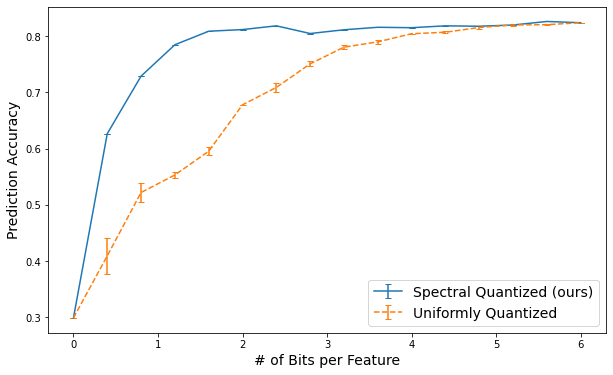

In [6]:
dataset = Planetoid(root='../dataset/Cora', name='Cora')
graph = dataset[0]
avg_deg=graph.edge_index.size(1)/graph.x.size(0)
nfeature = 16
nlayer = 3
org_size = 6
ndiv = 16
nrepeat = 5
# PCA transform the sparse features
pca = PCA(n_components=nfeature)
pca = pca.fit(graph.x.numpy())
X = graph.x.numpy()
y = graph.y.numpy()
X_pca = pca.transform(X)
# GCN convolution matrix
A, L, C = get_topology_matrices(graph)
freqs, U = get_eigen_system(L)
spec_mag = spectral_magnitude(X_pca, U)
# S-GNC multi-layer 
C = np.linalg.matrix_power(C, nlayer)
# Clean baseline
clf = LogisticRegression(penalty='none', max_iter=1000).fit(C @ X_pca, y)
print('Clean score:', clf.score(C @ X_pca, y))
# Theoretically derived
responses_theory = gcn_response(size=graph.x.size(0), freqs=freqs, avg_deg=avg_deg, nlayer=nlayer, activation='ReLU')
# Emperically observed
responses_emperical = spectral_magnitude(C @ X_pca @ clf.coef_.transpose() + clf.intercept_, U)
responses = responses_theory
responses = responses / np.linalg.norm(responses, ord=np.inf, axis=0)
# Normalization and modularization
X_spec = U.transpose() @ X_pca
X_spec = X_spec / np.expand_dims(np.linalg.norm(X_spec, ord=np.inf, axis=0), axis=0)
X_spec = np.floor(X_spec * (np.power(2, org_size-1) - 0.5) - 0.5)
print('Pre-quantized max/min:', np.max(X_spec), np.min(X_spec))
# Pre-quantized baseline
clf = LogisticRegression(penalty='none', max_iter=1000).fit(C @ U @ X_spec / np.power(2, org_size-1), y)
print('Pre-quantized score:', clf.score(C @ U @ X_spec / np.power(2, org_size), y))
# Train and evaluate
qscores_mean = []
qscores_std = []
uniqscores_mean = []
uniqscores_std = []
comp_ratios = np.linspace(0, 1, ndiv)
for i, comp_ratio in enumerate(comp_ratios):
    # spectral quantization
    qscores = []
    for j in range(nrepeat):
        qmasks = quant_mask(responses=responses, comp_ratio=comp_ratio, nlayer=1, org_size=org_size)
        X_quant = np.floor((X_spec + np.power(2, org_size-1)) / np.expand_dims(np.power(2, qmasks), axis=1)
                          ) * np.expand_dims(np.power(2, qmasks), axis=1) - np.power(2, org_size-1)
        #print('Spectral quantized max/min:', np.max(X_quant), np.min(X_quant))
        clf = LogisticRegression(penalty='none', max_iter=1000).fit(C @ U @ X_quant / np.power(2, org_size-1), y)
        qscores.append(clf.score(C @ U @ X_quant / np.power(2, org_size-1), y))
        print("Progress: {:2.2f}%".format(50*(i*nrepeat*2+j+1)/ndiv/nrepeat), end='\r')
    qscores = np.array(qscores)
    qscores_mean.append(np.mean(qscores))
    qscores_std.append(np.std(qscores))
    # uniformly quantization baselin
    uniqscores = []
    for j in range(nrepeat):
        qmasks_uniform = quant_mask_uniform(len(responses), comp_ratio, org_size)
        X_uniquant = np.floor((X_spec + np.power(2, org_size-1)) / np.expand_dims(np.power(2, qmasks_uniform), axis=1)
                             ) * np.expand_dims(np.power(2, qmasks_uniform), axis=1) - np.power(2, org_size-1)
        #print('Uniformly quantized max/min:', np.max(X_uniquant), np.min(X_uniquant))
        clf = LogisticRegression(penalty='none', max_iter=1000).fit(C @ U @ X_uniquant / np.power(2, org_size-1), y)
        uniqscores.append(clf.score(C @ U @ X_uniquant / np.power(2, org_size-1), y))
        print("Progress: {:2.2f}%".format(50*(i*nrepeat*2+nrepeat+j+1)/ndiv/nrepeat), end='\r')
    uniqscores = np.array(uniqscores)
    uniqscores_mean.append(np.mean(uniqscores))
    uniqscores_std.append(np.std(uniqscores))
    
plt.figure(figsize=(10,6))
plt.errorbar(comp_ratios * org_size, qscores_mean, yerr=qscores_std, capsize=3, label="Spectral Quantized (ours)")
plt.errorbar(comp_ratios * org_size, uniqscores_mean, yerr=uniqscores_std, fmt='--', capsize=3, label="Uniformly Quantized")
plt.xlabel("# of Bits per Feature", fontsize=14)
plt.ylabel("Prediction Accuracy", fontsize=14)
plt.legend(fontsize=14)
plt.show()